# Belief Networks -  Full Notebook

This Jupyter Notebook accompanies the Notes for Dr. Bob's Notes Print on July 8, 2024
Last edited: Friday, July 26, 10:47AM

Table of Contents:
* 0 - Loading the Ground Truth, Experts, and Input Data
    * 0.1 Loading Ground Truth from MNIST
    * 0.2 Creating Experts using TensorFlow
    * 0.3 Loading Prebuilt Experts
    * 0.4 Loading New Images for Examples
* 1 - Probability Assessment
    * 1.1 Basic Assigment
    * 1.2 Density Function Shape
    * 1.3 Weighted Self Assessment - Expert Quality Score (p~)
    * 1.4 Weighted Self Assessment - Expert Self Assessment of Certitude (V*)
    * 1.5 and 1.6 Triangle Base Width and Triangle Height
    * 1.7 Certainty
* 2 - Belief Network Approach
    * 2.1 Rationale
    * 2.2 Basics
    * 2.3 Relative Importance
    * 2.4 Label Probabilities
    * 2.5 Sampling
    * 2.6 An Example
    * 2.7 A Few more Examples
    * 2.8 Multiple Experts at Work (Convolution of uncertainties)
        * 2.8.1 Convolution of Certainties
        * 2.8.2 Convolution of Certainty with Uncertainty
    * 2.9 An Example of Combining Experts
    * 2.10 A Priori Evaluations
        * 2.10.1 Algorithm1
        * 2.10.2 Algorithm Acceleration
        * 2.10.3 Acceleration Results - Label Elimination
        * 2.10.4 Acceleration Results - Photo Elimination
        * 2.10.5 Histogram Construction
        * 2.10.6 An Example
    * 2.11 Recovery of P[Phi] from P[L] and Recovery of P[L] from P[Phi]
        * 2.11.1 Linear Programming
        * 2.11.2 The Problem at Hand
        * 2.11.3 The Simplex Method
        * 2.11.4 Vertex Traversal
        * 2.11.5 Ideal Case (Exact Solution)
        * 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
        * 2.11.7 Non-ideal Case: Supremum Norm Minimization
        * 2.11.8 Supremum Norm vs Coordinate Minimization
        * 2.11.9 Objective Function Minimization
        * 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm
        * 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm
        * 2.11.12 Non-Ideal Case: Monte-Carlo Techniques
    * 2.12 A Posteriori Evaluations
        * 2.12.1 Algorithm 2
        * 2.12.2 Alternate Algorithms
        * 2.12.3 An Example Implementation


    

# 0 - Loading the Experts, Ground Truth, and Input Data


### 0.1 - Creating the Ground Truth Set.   

The Ground Truth Set will be   {Phi1, Phi2, Phin N} where N =10000.  
They will be obtained by using the test_images in the mnist data set.  
Note, we do not need their associated labels. We are simply using the image data.  

In [1]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import csv
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model
from scipy.optimize import minimize


# Importing the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

/Users/christopherwaight/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 0.2 - Creating Expert Models using Training Loop

If you have experts to load, skip this step.  

In Lieu of Human Experts, we will create 11 Models.  
10 will be considered experts and used to create the Belief Network.  
The 11th will be saved for later.

NB. Be sure to update the save location model_path = f"mnist_expert{epoch}.keras"  # Path to save the model

In [2]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import models, layers

# # Random Seed
# np.random.seed(12883)

# # Create the model
# model = models.Sequential([
#     layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.BatchNormalization(),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')
# ])

# model.summary()

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Training loop to save 10 different models
# for epoch in range(1,11):  # From epoch 1 to 11 gives us 10
#     print(f"Training epoch {epoch}")
#     current_size = int(4096/(2**(epoch-1)))  # Halve the batch size every epoch
#     model.fit(train_images, train_labels, epochs=1, batch_size=current_size, validation_split=0.33) # Train the model for 1 epoch
#     model_path = f"mnist_expert{epoch}.keras"  # Path to save the model
#     model.save(model_path)  # Save the model
#     print(f"Model saved to {model_path}")

#     # Evaluate the model on the test set
#     test_loss, test_acc = model.evaluate(test_images, test_labels)
#     print(f"Test accuracy after epoch {epoch}: {test_acc}")


### 0.3 - Loading Experts

If you have predefined experts, they can be loaded from here.  
Be sure to update the file paths as needed.

In [3]:
# List of model paths
model_paths = [f"mnist_expert{i+1}.keras" for i in range(10)]
scores = []

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    #print(f"Test accuracy of Expert {i+1}: {test_acc}")  # Print test accuracy
    scores.append(test_acc)  # Append test accuracy to scores list

print("The 10 experts have been loaded")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4926 - loss: 2.1434
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5654 - loss: 2.0887
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.2935
The 10 experts have been loaded


### 0.4 - Load the New Input Data Psi

Here, we can load a brand new image to use on Algorithm1 or Algorithm2 Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


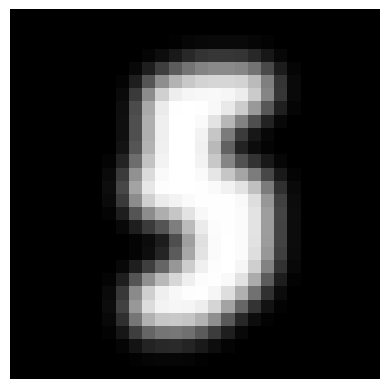

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Load a new image
image_path = "new_character2.JPG"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_gray, (28, 28))
image_resized = 1 - (image_resized / 255.0)
image_resized[image_resized < 0.50] = 0
image_resized = cv2.medianBlur(np.float32(image_resized), 3)

# Apply various image processing techniques
kernel = np.ones((2, 2), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

kernel = np.ones((1, 3), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
#print('Model 11 predicts:', np.argmax(guess))
#print('Softmax outputs:', np.round(guess, 3))
#print()

# Display the image
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

# 1 - Probability Assessment

### 1.1 - 1.2

Let's cover some basic definitions and nomenclature. 
 
[Notes need to be copied from Handwritten Book]  
[No Code Needed]

### 1.3 Weighted Self Assement : p~ component or " Expert Quality Score"

In [5]:
import numpy as np
from tensorflow.keras.models import load_model

# List of model paths
model_paths = [f"mnist_expert{i+1}.keras" for i in range(10)]
scores = []         # Scores is also used in section 2.11.8

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    scores.append(test_acc)  # Append test accuracy to scores list

print("The Quality Scores for each Expert is :", np.round(scores,4))
print("Scores in ascending order:", sorted(np.round(scores,4)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4926 - loss: 2.1434
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5654 - loss: 2.0887
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.2935
The Quality Scores for each Expert is : [0.5133 0.7389 0.6785 0.6525 0.8701 0.9096 0.9474 0.5685 0.8501 0.9549]
Scores in ascending order: [0.5133, 0.5685, 0.6525, 0.6785, 0.7389, 0.8501, 0.8701, 0.9096, 0.9474, 0.9549]


### 1.4 Weighted Self Assement : V* component or " Self Certainty Score"

In this section, each expert is asked to provide a label "0,1,2,....9" to each image in the Ground Truth Data Set.  
Furthermore, the expert is asked to give their "Self Certainty Score".  

Since our experts are super human, we can use gradations of 0.01 instead of 0.3

Furthermore, instead of simply giving a reading of  
"Given Phi 1, Expert 1 assigns the label : 8, with a self certainty of: 0.11"  
Our experts give their self certainty for each possible label.:

"Given Phi 1, Expert 1 assigns the label : 0, with a self certainty of: 0.03"   
"Given Phi 1, Expert 1 assigns the label : 2, with a self certainty of: 0.05"     
...   
"Given Phi 1, Expert 1 assigns the label : 9, with a self certainty of: 0.15"  



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Each Expert rated 10,000 images
Below are 16 random images from this Ground Truth Set
It shows the phi Index
And the Label each expert assigns to it


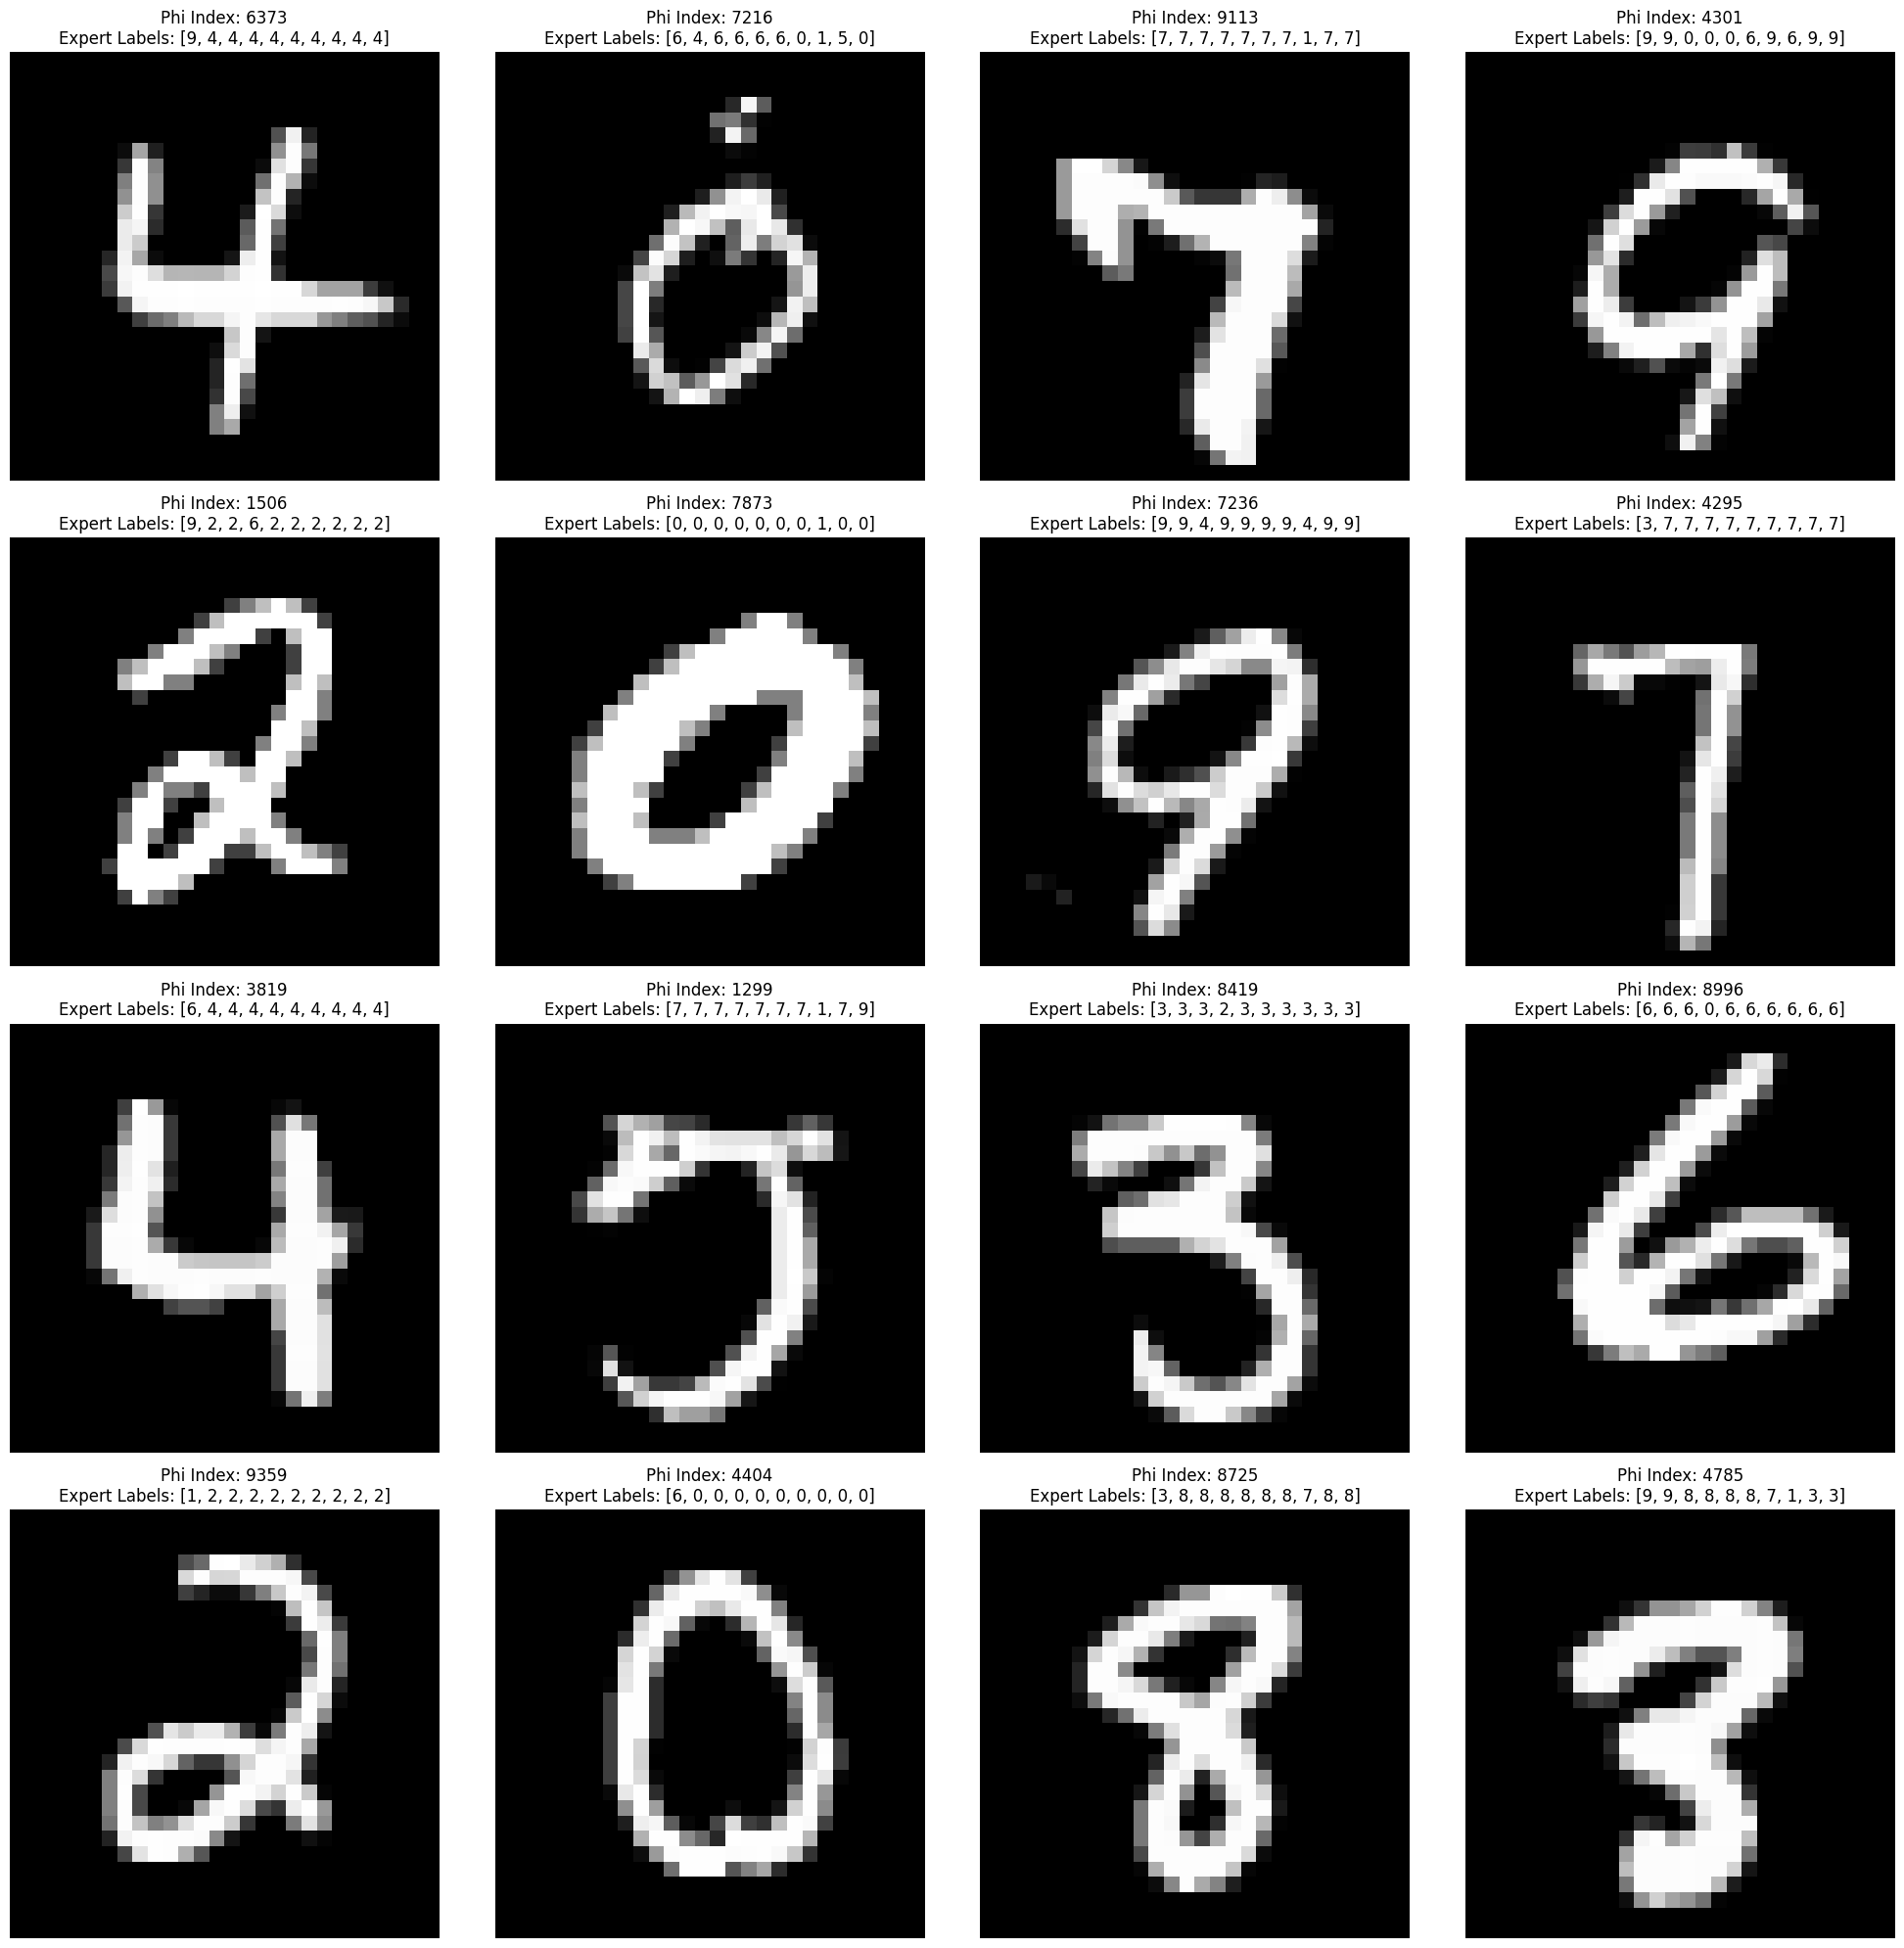


Given the Ground Truth Photo Index: 6373
Expert 1 assigns the label : 9, with a self certainty of: 0.11
Expert 2 assigns the label : 4, with a self certainty of: 0.14
Expert 3 assigns the label : 4, with a self certainty of: 0.14
Expert 4 assigns the label : 4, with a self certainty of: 0.33
Expert 5 assigns the label : 4, with a self certainty of: 0.59
Expert 6 assigns the label : 4, with a self certainty of: 0.69
Expert 7 assigns the label : 4, with a self certainty of: 0.98
Expert 8 assigns the label : 4, with a self certainty of: 0.13
Expert 9 assigns the label : 4, with a self certainty of: 1.0
Expert 10 assigns the label : 4, with a self certainty of: 0.92

Given the Ground Truth Photo Index: 7216
Expert 1 assigns the label : 6, with a self certainty of: 0.12
Expert 2 assigns the label : 4, with a self certainty of: 0.13
Expert 3 assigns the label : 6, with a self certainty of: 0.2
Expert 4 assigns the label : 6, with a self certainty of: 0.13
Expert 5 assigns the label : 6, wit

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []
predicted_classes = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(test_images)  # Predict with the model
    predictions.append(pred)
    predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# True classes
true_classes = np.argmax(test_labels, axis=1)

# Identify misclassified examples for each model
misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# Count misclassifications for each image
misclassification_counts = {}
for model_misclassified_indices in misclassified_by_model:
    for index in model_misclassified_indices:
        misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# Sort indices by the number of times they were misclassified, in descending order
sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# Display 16 random images from misclassified indices in a 4x4 grid
random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

print()
print('Each Expert rated 10,000 images')
print('Below are 16 random images from this Ground Truth Set')
print('It shows the phi Index')
print('And the Label each expert assigns to it')


for ax, index in zip(axes.flatten(), random_misclassified_indices):
    ax.imshow(test_images[index].reshape(28, 28), cmap='gray')
    predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
    ax.set_title(f"Phi Index: {index}\nExpert Labels: {predictions_for_plot}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print prediction and softmax output for each randomly selected misclassified index
for index in random_misclassified_indices:
    print()
    print(f"Given the Ground Truth Photo Index: {index}")
    for i in range(num_models):
        self_certainty = np.round(np.max(predictions[i][index]),2)
        print(f"Expert {i+1} assigns the label : {predicted_classes[i][index]}, with a self certainty of:" , self_certainty)


#### For Debugging only - Smaller Ground Truth

You may want to use a smaller Ground Truth. Here is the code to only use 100 photos instead.

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# # True classes from the full test_labels
# true_classes_full = np.argmax(test_labels, axis=1)

# # Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
# indices_per_class = 10  # Number of indices per class to achieve 100 images total
# selected_indices = []

# for digit in range(10):
#     digit_indices = np.where(true_classes_full == digit)[0]
#     selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
#     selected_indices.extend(selected_digit_indices)

# # Ensure the selected indices are shuffled to mix the digits
# np.random.shuffle(selected_indices)

# # Slicing the test_images and test_labels to get only the selected subset
# subset_test_images = test_images[selected_indices]
# subset_test_labels = test_labels[selected_indices]

# # Load models and get predictions
# num_models = 10  # Specify the number of models
# predictions = []
# predicted_classes = []

# for i in range(1, num_models + 1):
#     model = load_model(f"mnist_expert{i}.keras")  # Load each model
#     pred = model.predict(subset_test_images)  # Predict with the model on the subset
#     predictions.append(pred)
#     predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# # True classes for the subset
# true_classes = np.argmax(subset_test_labels, axis=1)

# # Identify misclassified examples for each model
# misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# # Count misclassifications for each image in the subset
# misclassification_counts = {}
# for model_misclassified_indices in misclassified_by_model:
#     for index in model_misclassified_indices:
#         misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# # Sort indices by the number of times they were misclassified, in descending order
# sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# # Display 16 random images from misclassified indices in a 4x4 grid
# random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

# for ax, index in zip(axes.flatten(), random_misclassified_indices):
#     ax.imshow(subset_test_images[index].reshape(28, 28), cmap='gray')
#     predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
#     ax.set_title(f"Index: {index}\nExpert Labels: {predictions_for_plot}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

# # Print prediction and softmax output for each randomly selected misclassified index
# for index in random_misclassified_indices:
#     print(f"Index: {index}")
#     for i in range(num_models):
#         print(f"Model {i+1} prediction: {predicted_classes[i][index]}, softmax output: {np.max(predictions[i][index])}")


### 1.5 - 1.6 Triangle Height and Width for Uncertainty.

Sections 1.5 and 1.6 describe how p~ and V* can be used to create Triangular Probability Density functions.

Instead, this notebook will use Normal Functions as Probability Densities instead of Triangular Probability Density functions.

In this implementation, Probability Density Functions are created as follows:

f = (mean, std_dev)  
f = (p*V~, insert here)  
f = clip f between 0 and 1  

This approach creates Probability Density Functions with the following Properties:
* Area under Clipped Normal curve equals to 1
* All values between 0 and 1
* Independence, each expert is independent of others, and each photograph rating is indepdent. In other words, experts don't get smarter / learn as they go and can't peak at other experts to influence their decisions.

The mean (mu) is calculated as mu = p*v~ and the standard deviation  is sqrt (mu * (1-mu) / Num_samples ).  

NB. In the event that p*V~ is very close to 0, or very close 1, it is better to treat this as a certainty than as an uncertainty (see 1.7)


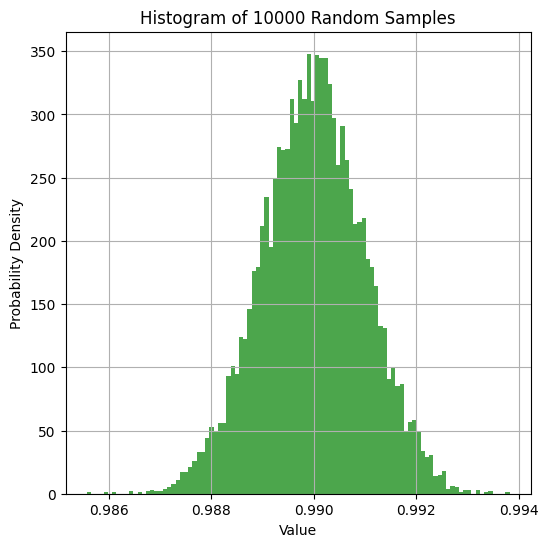

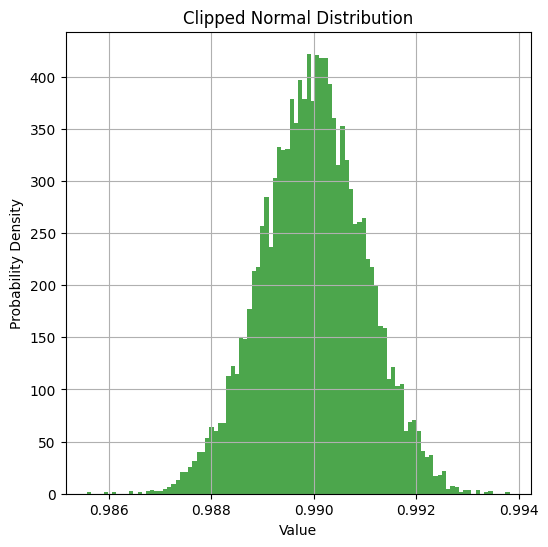

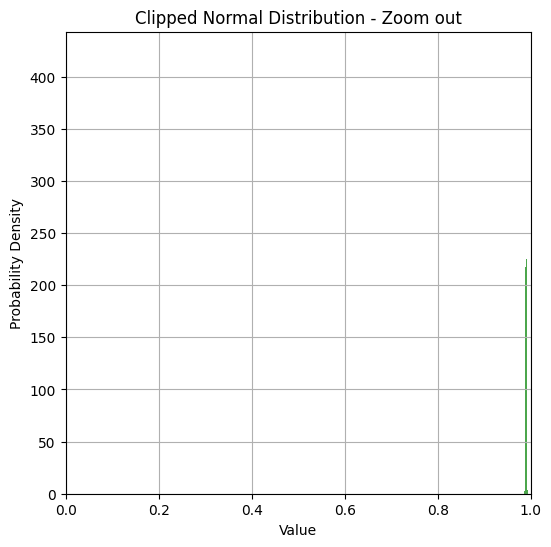

In [8]:
### Try this code with different values for Self Certainty !!!!

self_certainty_test_value = 0.99

import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = self_certainty_test_value
n_samples = 10_000  # Each expert takes n_samples of tests to determine their quality score
sigma = np.sqrt(mu*(1-mu)*(1/n_samples))


# Generating samples
samples = np.random.normal(mu, sigma, n_samples)

# Clipping samples
clipped_samples = np.clip(samples, 0, 1)


# Plotting normalized histogram
plt.figure(figsize=(6, 6))
plt.hist(samples, bins=100, color='green', alpha=0.7, density=False)
plt.title(f"Histogram of {n_samples} Random Samples")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


# Plotting normalized histogram
plt.figure(figsize=(6, 6))
plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
plt.title('Clipped Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


# Plotting normalized histogram
plt.figure(figsize=(6, 6))
plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
plt.title('Clipped Normal Distribution - Zoom out')
plt.xlabel('Value')
plt.xlim(0, 1)  # Setting the x-axis limits to [0, 1]
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


### 1.7 Certainty

In the case of certainty, we use a dirac-delta function.  
In implementation, what this means is that instead of sampling from a fxn, we use a constant value.

Notice, if the score is .999 and only 1000 tests were taken, then the histogram in 1.6 becomes very distorted from Normal.

[No Code For this Section]

# 2 Belief Network Approach

### 2.1 - 2.2 Rationale and the Basics

[ Definitions and Notes need to be added]  
[No Code Needed]

### 2.3 - 2.4 Relative Importance and Label Probabilities

[ Definitions and Notes need to be added]  
[No Code Needed]

### 2.5 Sampling

Sampling can be done by usign a cummulative distribution fucntion, then uniform sampling between 0 and 1.

However, in this notebook, we are using samlping tools such as np.random.uniform and np.random normal.

[No code needed]

### 2.6 Belief Networks - An Example

Using Figure 3 from the notebook.

Let the Phi's be .7/.91 , .2/.91 , .01/.91

We will let these have a sigma of 0.01/ sqrt(12)

To get the sigmas from triangle functions, we will let the base span/ sqrt(12)

Photo, Label, Inference, Left End, Centre, Right End, Mu, standard deviation.  
1 L1 f11  0.5  0.75  1.0  0.75, 0.083  
1 L2 f12  0.8  0.90  1.0  0.9,  0.033  
2 L1 f21  0.7  0.80  0.9  0.8   0.033  
2 L2 f23  0.3  0.40  0.5  0.4   0.033  
3 L3 f33  0.9  0.95  1.0  0.9   0.017  

This will be a 3x3 Matrix,  
f11 f12 f13  
f21 f22 f23  
f31 f32 f33  
With all missing entries from above equal to 0

NB. The output has different values than Dr. Bob's work.  

For comparison, I will also use hardcoded Values for my best guess of what E[x] should be.

Mean of 1 0.7747354983446366
Mean of 2 0.7031748646018897
Mean of 3 0.010484509960892728
Now using only the means (no sampling)
[0.77472527 0.7032967  0.01043956]


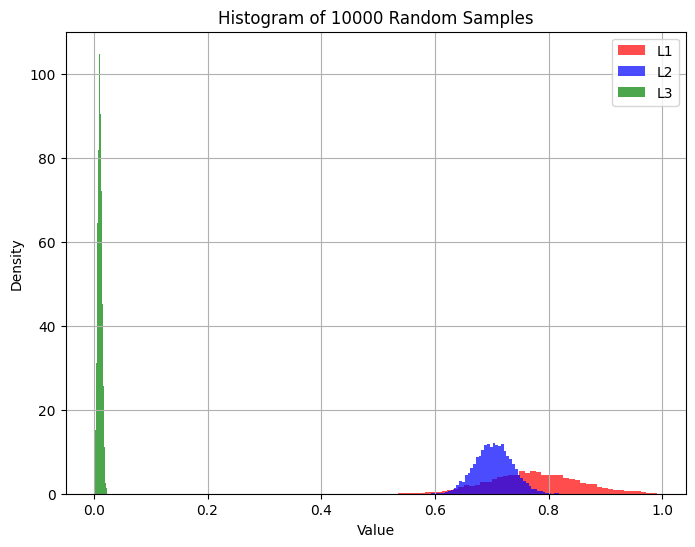

In [9]:
iterations = 10_000
allvalues = []

for _ in range(iterations):
    phis = np.array([np.random.normal(0.7 / 0.91, 0.0041), np.random.normal(.2/.91, 0.0041), np.random.normal(.01/.91, 0.0041) ])
    phis = np.clip(phis,0,1)

    F1 = np.array([np.random.normal(0.75, .102), np.random.normal(.9,.041), 0 ])
    F2 = np.array([np.random.normal(0.8, .041), np.random.normal(.4, .041), 0 ])
    F3 = np.array([0,0, np.random.normal(0.95, 0.02) ])
    F = np.vstack([F1,F2,F3])
    F = np.clip(F,0,1)
    dotprod = F.dot(phis)
    allvalues.append(dotprod)

# Plotting normalized histogram
allvalues = np.array(allvalues)

print('Mean of 1', np.mean(allvalues[:,0]))
print('Mean of 2', np.mean(allvalues[:,1]))
print('Mean of 3', np.mean(allvalues[:,2]))

print ('Now using only the means (no sampling)')

A = np.vstack([[0.75,.9,0],[0.8,0.4,0],[0,0,.95]])
b = np.array([0.7,0.2,0.01])/.91
exval = A.dot(b)
print(exval)

# Plotting normalized histogram
plt.figure(figsize=(8, 6))

# Colors for each column
colors = ['red', 'blue', 'green']
labels = ['L1', 'L2', 'L3']

# Plot histograms for each column
for i in range(allvalues.shape[1]):
    plt.hist(allvalues[:, i], bins=50, alpha=0.7, density=True, color=colors[i], label=labels[i])

plt.title(f"Histogram of {iterations} Random Samples")
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

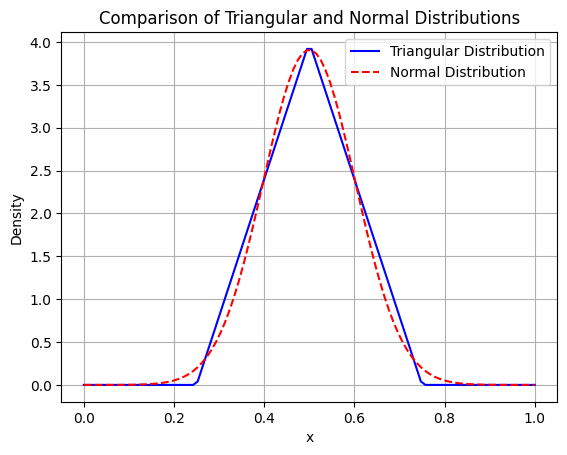

Triangular Distribution Mean: 0.4999100598584372
Triangular Distribution Variance: 0.010406756010595415
Normal Distribution Mean: 0.5000824581223784
Normal Distribution Variance: 0.010417346514143222
Normal Distribution Deviation: 0.10201350896129108


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, triang

# Parameters for the triangular distribution
a, b, c = 0.25, 0.5, 0.75

# Parameters for the normal distribution
mu = b
sigma = np.sqrt( ( a*a + b*b + c*c - a*b -a*c -b*c) /18  )

# Create an array of x values
x = np.linspace(0,1,100)

# Triangular distribution
height = 2 / (c - a)
width = c-a

triangular = triang.pdf(x, (b-a)/(c-a), loc=a, scale=(c-a))

# Normal distribution
normal = norm.pdf(x, mu, sigma)

# Plot the distributions
plt.plot(x, triangular, label='Triangular Distribution', color='blue')
plt.plot(x, normal, label='Normal Distribution', color='red', linestyle='dashed')
plt.title("Comparison of Triangular and Normal Distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Sampling
n_samples = 1_000_000

# Sample from triangular distribution
triangular_samples = np.random.triangular(a, b, c, n_samples)

# Sample from normal distribution
normal_samples = np.random.normal(mu, sigma, n_samples)

# Calculate mean and variance for both samples
triangular_mean = np.mean(triangular_samples)
triangular_variance = np.var(triangular_samples)

normal_mean = np.mean(normal_samples)
normal_variance = np.var(normal_samples)
normal_standarddec = np.sqrt(triangular_variance)

# Print the results
print(f"Triangular Distribution Mean: {triangular_mean}")
print(f"Triangular Distribution Variance: {triangular_variance}")
print(f"Normal Distribution Mean: {normal_mean}")
print(f"Normal Distribution Variance: {normal_variance}")
print(f"Normal Distribution Deviation: {normal_standarddec}")


### 2.7 Another Example

[For Varun: Try to replicate one of these with the numbers above. Determine the std dev using the code above too]


### 2.8 Combining Experts

This code shows the convolution of triangles

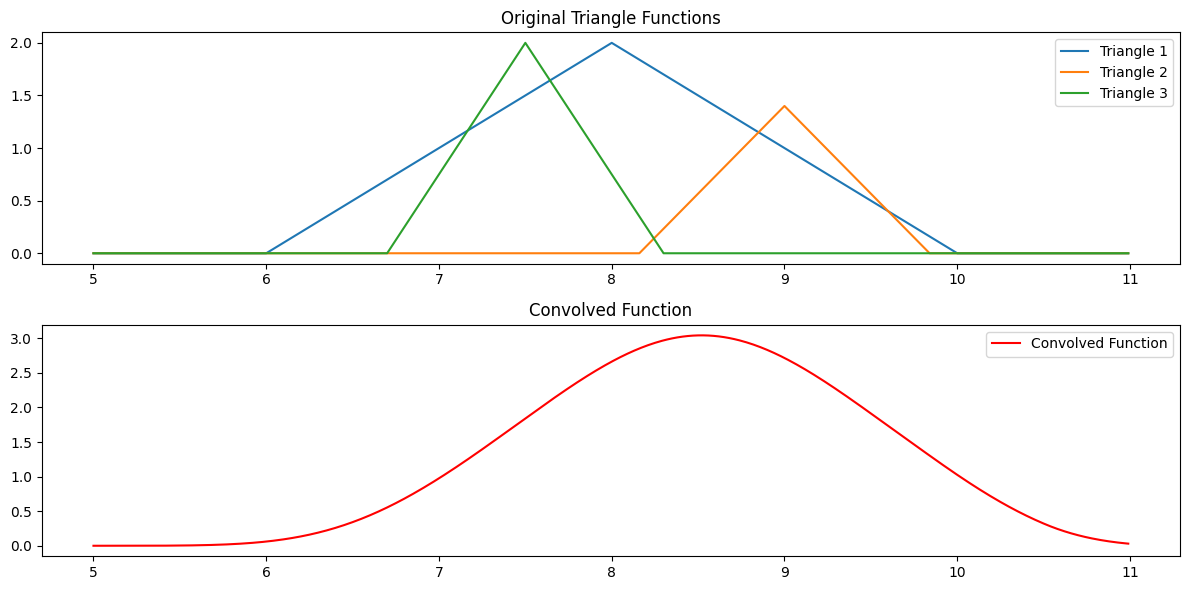

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the discretization step
dx = 0.01

# Define the ranges for the functions
x = np.arange(5, 11, dx)

# Define the first triangle function, centered at 8.0, height=1, width=2
def triangle(x, center, width, height):
    return np.maximum(height - np.abs(x - center) / (width / 2), 0)


# Calculate the triangle functions
y1 = triangle(x, 8, 2, 2)
y2 = triangle(x,9,1.2,1.4)
y3 = triangle(x,7.5,0.8,2)
# Perform the convolution
y_convolved = np.convolve(y1, y2, mode='same') * dx
y_convolved_again = np.convolve(y_convolved, y3, mode='same') * dx


# Adjust the x-axis for the convolution result to match its length
x_convolved = np.linspace(x.min(), x.max(), len(y_convolved_again))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(x, y1, label='Triangle 1')
plt.plot(x, y2, label='Triangle 2')
plt.plot(x, y3, label='Triangle 3')
plt.title('Original Triangle Functions')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x_convolved, y_convolved_again, color='red', label='Convolved Function')
plt.title('Convolved Function')
plt.legend()

plt.tight_layout()
plt.show()


However, using Normals, we are able to Convolve in the following way:

Mean = mu1 + mu2 / count(means)

var = (var1 + var2 )/(count(vars)**2)
 

prediceted mean  0.6
0.5998891973668855

predicted variance 0.002011111111111111
0.002010316783194649


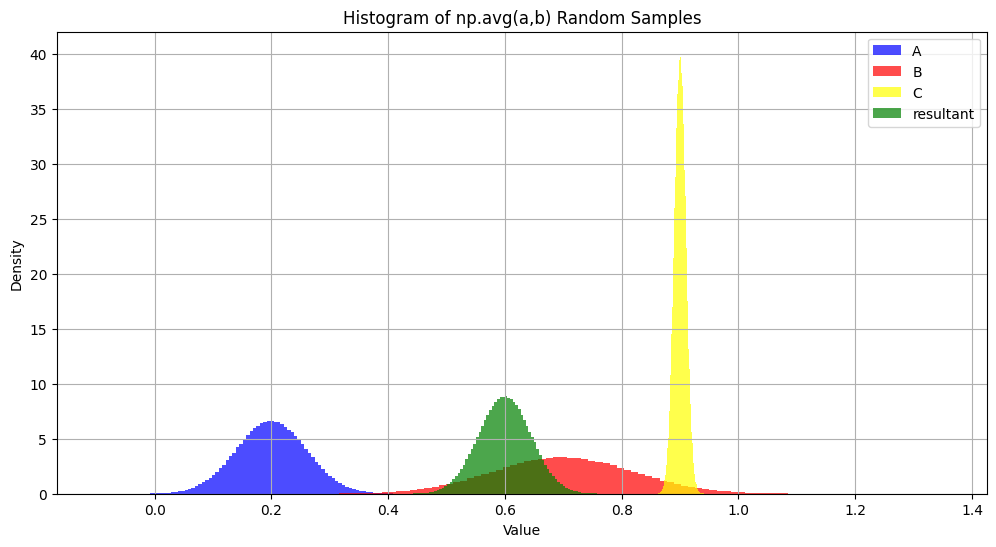

In [12]:
sums = []
a_s = []
bs = []
cs = []
mu1 = .2
var1 = .06

mu2 = .7
var2 = 0.12

mu3 = .9
var3 = 0.01

for _ in range(1_000_000):
    a = np.random.normal(mu1,var1)
    b =  np.random.normal(mu2,var2)
    c =  np.random.normal(mu3,var3)
    #a=np.clip(a,0,1)
    #b=np.clip(b,0,1)
    #c=np.clip(c,0,1)
    a_s.append(a)
    bs.append(b)
    cs.append(c)
    ab_avg = (a+b+c)/3
    sums.append(ab_avg)

# Plotting
plt.figure(figsize=(12, 6))

total_mean = np.mean([mu1,mu2,mu3])
print("prediceted mean ", total_mean)
print(np.mean(sums))
print()
totalvar = (var1**2 + var2**2 + var3**2 ) /9  #+ np.var([mu1,mu2])
print("predicted variance", totalvar )
print(np.var(sums))


plt.hist(a_s, bins=100, alpha=0.7, density=True, color = 'blue', label= 'A')
plt.hist(bs, bins=100, alpha=0.7, density=True, color = 'red', label= 'B')
plt.hist(cs, bins=100, alpha=0.7, density=True, color = 'yellow', label= 'C')
plt.hist(sums, bins=100, alpha=0.7, density=True, color = 'green', label= 'resultant')

plt.title(f"Histogram of np.avg(a,b) Random Samples")
plt.xlabel('Value')
plt.legend()
plt.ylabel('Density')
plt.grid(True)


### 2.9 Belief Networks - Combining Experts Example

Using the Convolution Techniques in 2.8, All "Single Expert Belief Systems" are convolved into a single "Ensemble of Experts Belief System"

In [13]:
# Initialize variables
n = 10_000 # Number of samples
accuracies = np.array(scores)  # This can be found in section 1.3

# Standard deviation for each model
standard_deviations = np.sqrt(accuracies * (1 - accuracies) / n) 

# Calculating the outputs from several expert models
softmax_outputs = []
for path in model_paths:
    model = load_model(path)
    predictions = model.predict(test_images)
    softmax_outputs.append(predictions)

# Initialize a 3D array to store the results # Shape: (2 metrics, 10 classes, number of images)
results = np.zeros((2, 10, len(test_images)))  

# For each Image
for index in range(len(test_images)):  # Assuming test_images is defined
    for class_idx in range(10):  # Assuming 10 classes
        total_confidence = []
        total_devs = []

        
        for i, softmax_output in enumerate(softmax_outputs):
            confidence_score = softmax_output[index, class_idx]  # Confidence score for this class from the i-th model
            scaled_confidence = confidence_score * accuracies[i]  # Scaled confidence score
            
            total_confidence.append(scaled_confidence)
            total_devs.append(standard_deviations[i])  # I am not sure I am doing this right
        
        # Calculate averages for this class for this image
        avg_confidence = np.mean(total_confidence)
        total_variance = np.sum([dev**2 for dev in total_devs])/100 # Hard coded value is 10^2 factor.
        
        
        # Store the averages in the results array
        results[0, class_idx, index] = avg_confidence
        results[1, class_idx, index] = total_variance**0.5


# Example: Print the results for the first image across all classes for each metric
#print(f"Average Confidence Scores for Image 0: {results[0, :, 0]}")
#print(f"Average standard deviation for Image 0: {results[1, :, 0]}")
#print(f"True class: {true_classes[0]}, argmax: {np.argmax(results[0, :, 0])}")

print(" All convolutions complete. Belief Network successfully compiled")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 All convolutions complete. Belief Network successfully compiled


### 2.10.1 - 2.10.4 Algorithm1 and acceleration techniques

This Describes Algorithm 1.



It then describes some acceleration techniques in 2.10-2.10.4.
I am not implementing these.
[no code needed]

### 2.10.5 Histogram

This section describes how to collect a Histogram of results, similiar to 2.6
It proposes we can use this histogram as a probability function which is the certitude that a label corresponds to the given image.

This would be a very memory intensive approach. An alternative approach is to fit a normal distribution to these histograms and use those instead. Below show 

Mean of 1 0.7744040557145636
Mean of 2 0.7032756948581529
Mean of 3 0.010398234510409339

Variance of 1 0.006155931374312709
Variance of 2 0.0010673399845306767
Variance of 3 1.5094524005129088e-05
Now using only the means (no sampling)
[0.77472527 0.7032967  0.01043956]


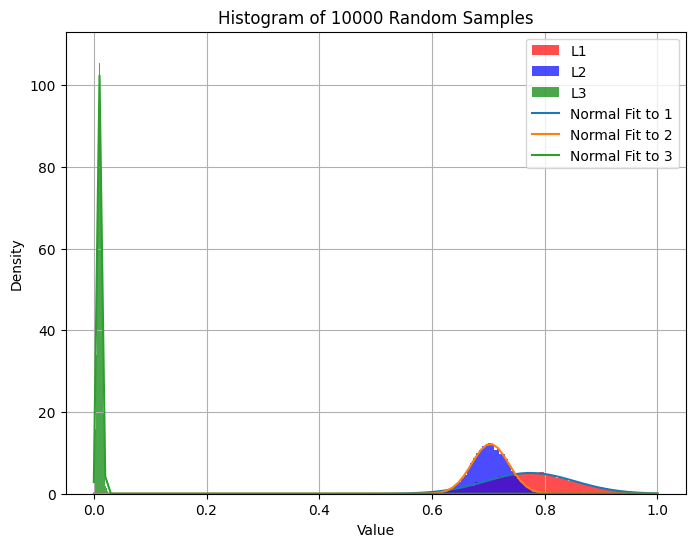

In [14]:
iterations = 10_000
allvalues = []

for _ in range(iterations):
    phis = np.array([np.random.normal(0.7 / 0.91, 0.0041), np.random.normal(.2/.91, 0.0041), np.random.normal(.01/.91, 0.0041) ])
    phis = np.clip(phis,0,1)

    F1 = np.array([np.random.normal(0.75, .102), np.random.normal(.9,.041), 0 ])
    F2 = np.array([np.random.normal(0.8, .041), np.random.normal(.4, .041), 0 ])
    F3 = np.array([0,0, np.random.normal(0.95, 0.02) ])
    F = np.vstack([F1,F2,F3])
    F = np.clip(F,0,1)
    dotprod = F.dot(phis)
    allvalues.append(dotprod)

# Plotting normalized histogram
allvalues = np.array(allvalues)

print('Mean of 1', np.mean(allvalues[:,0]))
print('Mean of 2', np.mean(allvalues[:,1]))
print('Mean of 3', np.mean(allvalues[:,2]))
print()
print('Variance of 1', np.var(allvalues[:,0]))
print('Variance of 2', np.var(allvalues[:,1]))
print('Variance of 3', np.var(allvalues[:,2]))


print ('Now using only the means (no sampling)')

A = np.vstack([[0.75,.9,0],[0.8,0.4,0],[0,0,.95]])
b = np.array([0.7,0.2,0.01])/.91
exval = A.dot(b)
print(exval)

# Plotting normalized histogram
plt.figure(figsize=(8, 6))

# Colors for each column
colors = ['red', 'blue', 'green']
labels = ['L1', 'L2', 'L3']

# Plot histograms for each column
for i in range(allvalues.shape[1]):
    plt.hist(allvalues[:, i], bins=50, alpha=0.7, density=True, color=colors[i], label=labels[i])


# Create an array of x values
x = np.linspace(0,1,100)

# Normal distributions
y1 = norm.pdf(x, np.mean(allvalues[:,0]), np.std(allvalues[:,0]))
y2 = norm.pdf(x, np.mean(allvalues[:,1]), np.std(allvalues[:,1]))
y3 = norm.pdf(x, np.mean(allvalues[:,2]), np.std(allvalues[:,2]))

plt.plot(x, y1, label='Normal Fit to 1')
plt.plot(x, y2, label='Normal Fit to 2')
plt.plot(x, y3, label='Normal Fit to 3')



plt.title(f"Histogram of {iterations} Random Samples")
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

### 2.10.6 A Priori Example


L=F*Phi

Given:
* F - The belief network distributions
* Phi - How much it looks like each image

Solve:
* L - Which labels, and with what certainty

##### If we Knew Phi Somehow

https://en.wikipedia.org/wiki/Structural_similarity_index_measure#Algorithm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



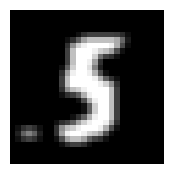

Highest phi index: 2951, with phi value: 0.0002749068152403228


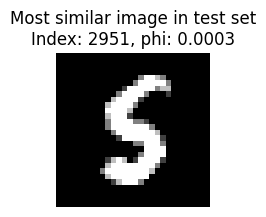

Sum of all phi values 0.9999999999999999


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Load a new image
image_path = "new_character2.JPG"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_gray, (28, 28))
image_resized = 1 - (image_resized / 255.0)


#image_resized = cv2.medianBlur(np.float32(image_resized), 3)
#image_resized = cv2.medianBlur(np.float32(image_resized), 3)
# Apply various image processing techniques
kernel = np.ones((2, 2), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)
image_resized[image_resized < 0.85] = 0
image_resized[image_resized > 0.85] = 1

kernel = np.ones((1, 3), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
#print('Model 11 predicts:', np.argmax(guess))
#print('Softmax outputs:', np.round(guess, 2))
print()

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
import cv2


# Placeholder for SSIM scores
ssim_scores = []

# Iterate over each test image
for test_image in test_images:
    # Resize the test image to 28x28
    test_image = cv2.resize(test_image, (28, 28))
    ssim = compare_ssim(image_resized, test_image, data_range=test_image.max() - test_image.min())
    ssim_scores.append(ssim)

# Find the index of the test image with the highest SSIM score

ssim_scores = ssim_scores/np.sum(ssim_scores) # Make this a probability distribution
max_ssim_index = np.argmax(ssim_scores)
max_ssim_value = ssim_scores[max_ssim_index]

print(f"Highest phi index: {max_ssim_index}, with phi value: {max_ssim_value}")

# If needed, display the most similar image
plt.figure(figsize=(2, 2))
plt.imshow(test_images[max_ssim_index], cmap='gray')
plt.title(f"Most similar image in test set\nIndex: {max_ssim_index}, phi: {max_ssim_value:.4f}")
plt.axis('off')
plt.show()

y=np.sum(ssim_scores)
print("Sum of all phi values", y)

In [16]:
np.random.seed(1023)  # Ensure reproducibility

# Assuming phi is a numpy array of shape (10000, 1)
def keep_top_k(phi, k):
    sorted_indices = np.argsort(-phi.flatten())  # Sort in descending order
    top_k_indices = sorted_indices[:k]
    phi_filtered = np.zeros_like(phi)
    phi_filtered[top_k_indices] = phi[top_k_indices]
    return phi_filtered

# Initialize Constants 
k = 100  # Number of largest elements to keep
phi = ssim_scores.copy()
phi = keep_top_k(phi, k)
phi = phi/np.sum(phi)
initial_phi = phi.copy()


num_classes = 10  # Number of classes
num_images = len(test_images)  # Assuming 'test_images' has been defined previously
new_dim = 1000  # The new dimension size


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)

# Use broadcasting to generate the new dimensions
phi_expanded = np.tile(phi, (new_dim, 1)).T 
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))

# Compute L using einsum for efficient computation
L2 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)



print()

L2_avg = np.mean(L2, axis=1)
L2_std = np.std(L2, axis=1)

print()
print("With given phi values, the Belief Network thinks this is a ", np.argmax(L2_avg))
print()
print("Average Label Values")

for idx in range(10):
    print(f'Class {idx}: ', np.round(L2_avg[idx],4))




With given phi values, the Belief Network thinks this is a  5

Average Label Values
Class 0:  0.0334
Class 1:  0.031
Class 2:  0.0544
Class 3:  0.1607
Class 4:  0.0289
Class 5:  0.2485
Class 6:  0.0451
Class 7:  0.0271
Class 8:  0.1096
Class 9:  0.0296


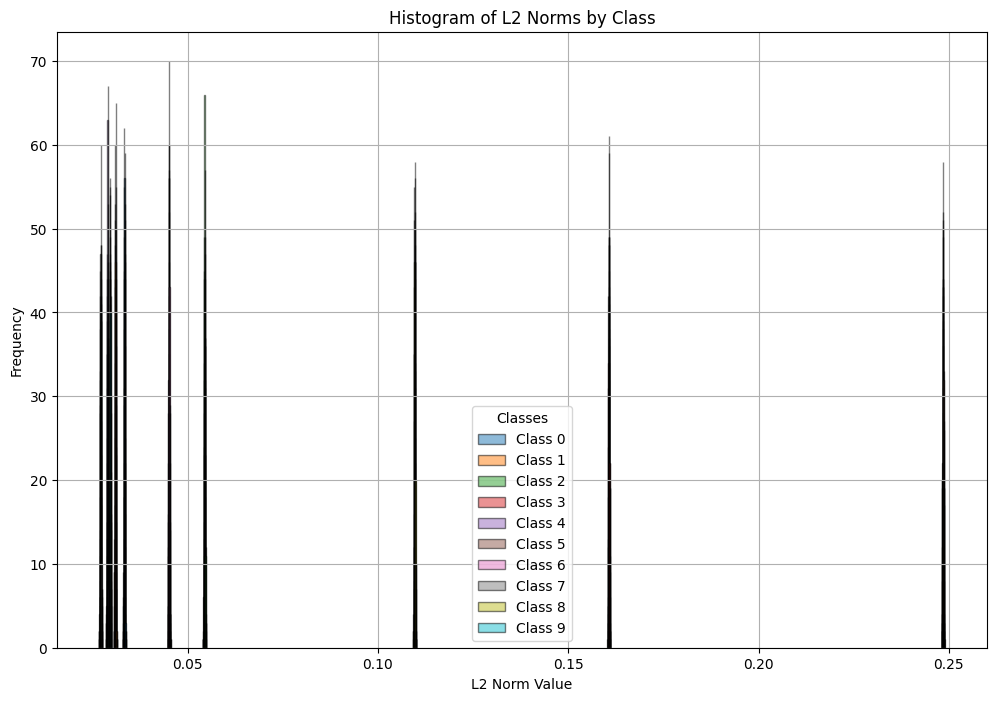

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming L2 is of shape (num_classes, num_images)
num_classes = L2.shape[0]

plt.figure(figsize=(12, 8))

# Plot a histogram for each class
for class_idx in range(num_classes):
    # Extract the L2 norms for the current class
    L2_class = L2[class_idx, :]
    
    # Plot histogram for this class
    plt.hist(L2_class, bins=50, alpha=0.5, label=f'Class {class_idx}', edgecolor='black')

# Add labels and title
plt.title('Histogram of L2 Norms by Class')
plt.xlabel('L2 Norm Value')
plt.ylabel('Frequency')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


### 2.11 - A Posteriori Example

* 2.11 Recovery of P[Phi] from P[L] and Recovery of P[L] from P[Phi]
    * 2.11.1 Linear Programming
    * 2.11.2 The Problem at Hand
    * 2.11.3 The Simplex Method
    * 2.11.4 Vertex Traversal
    * 2.11.5 Ideal Case (Exact Solution)
    * 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
    * 2.11.7 Non-ideal Case: Supremum Norm Minimization
    * 2.11.8 Supremum Norm vs Coordinate Minimization
    * 2.11.9 Objective Function Minimization
    * 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm
    * 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm
    * 2.11.12 Non-Ideal Case: Combining Reformulations
    * 2.11.12 Non-Ideal Case: Monte-Carlo Techniques
* 2.12 A Posteriori Evaluations
    * 2.12.1 Algorithm 2
    * 2.12.2 Alternate Algorithms
    * 2.12.3 An Example Implementation


### 2.11.1, 2.11.2 Linear Programming and  The Problem at Hand

#### Linear Programming

This section gives a quick overview of Linear Programming and Optimization. 


#### The Problem at Hand
In the a priori example, we know F, and Phi, and we compute L.

In this problem, we know L, and F, and want to find Phi with a few constraints.

This can be written as:  

Solve for Phi such that 

L=F*Phi  
phi <= 0  
sum(phi) <=1  

Quick Reminder:  
* F - The belief network distributions
* L - Which labels, and with what certainty
* Phi - How much it looks like each image


### 2.11.3, 2.11.4 -  Simplex Method and Vertex Walk

This section introduces the Simplex Method, and the Vertex walk algorithm by Avis.

The Simplex Method is a well known Linear Programming Algorithm for solving "The problem at hand". The details are not covered here, but are available in standard libraries.

The work from Avis has been expanded, and it has been shown that the algorithm to find all vertices of a polytope can run in polynomial time O(n^3)

The problem is that the numver of vertices scales like O(2^n / n^0.5) 

[ Proof Needed - but can be done by showing how the number of vertices follows the binomial distribution.]

### 2.11.5 - The Ideal Case

The ideal case is that a single solution to the problem at hand exists.

L=F*Phi  

Subject to:
phi >= 0  
sum(phi) <=1  



If there is only a single valid solution, a regression would give us the result. This is a guess and check method that is very fast and stable, but doesn't work in the non-ideal case.

In [18]:
import numpy as np

F = np.array([[1, 2, 3],
              [2, 3, 5],
              [3, 4, 7]])

F=F.T
L = np.array([12, 16, 28])
eps = 1e-2  # Small regularization term

# Calculate phi
phi = np.linalg.inv(F.T @ F + eps * np.eye(F.shape[1])) @ (F.T @ L)
print("phi:", phi)

# Check the result of F.T @ phi
result = F @ phi
print("F.T @ phi:", result)


phi: [-0.55659109  1.35617157  3.26893422]
F.T @ phi: [11.96255471 16.03106941 27.99362412]


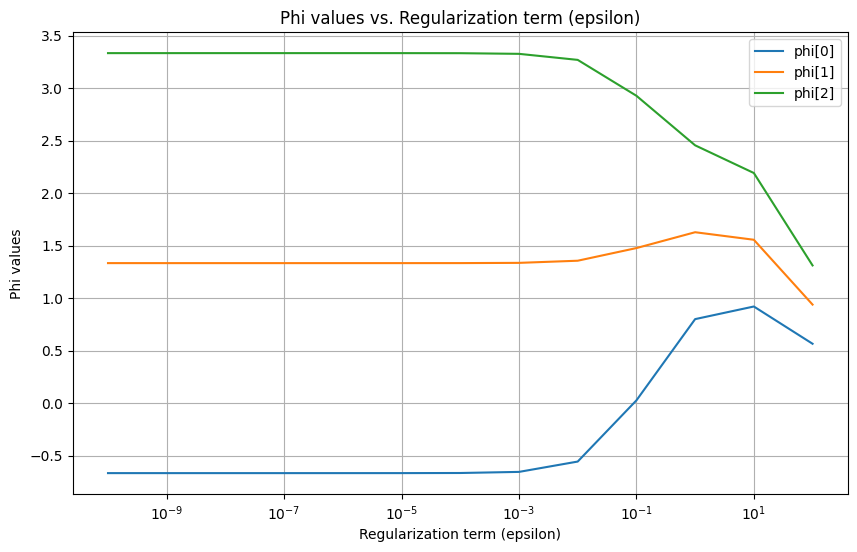

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
F = np.array([[1, 2, 3],
              [2, 3, 5],
              [3, 4, 7]]).T  # Transpose to correct orientation
L = np.array([12, 16, 28])

# Regularization terms
epsilons = [100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# Store all phi values
phi_values = []

# Calculate phi for each epsilon
for eps in epsilons:
    phi = np.linalg.inv(F.T @ F + eps * np.eye(F.shape[1])) @ (F.T @ L)
    phi_values.append(phi)

# Convert to a NumPy array for easy indexing
phi_values = np.array(phi_values)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(phi_values.shape[1]):
    plt.plot(epsilons, phi_values[:, i], label=f'phi[{i}]')

plt.xscale('log')
plt.xlabel('Regularization term (epsilon)')
plt.ylabel('Phi values')
plt.title('Phi values vs. Regularization term (epsilon)')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
L = guess.copy()
L = L.reshape(10,)

F = np.zeros((num_classes, num_images)) # (10, 10000)
# Populate the matrix F
for class_idx in range(num_classes):
    for image_idx in range(num_images):
        mean_confidence = results[0, class_idx, image_idx]  # Average confidence for this class & image
        std_deviation = results[1, class_idx, image_idx]  # Standard deviation for this class & image
        
        F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)

# Solve for Phi using the method of least squares
phi, residuals, rank, s = np.linalg.lstsq(F, L, rcond=None)

print("Given L",np.round(L,3))
print('Phi can be found :', phi)
print()
print('Checking Constraints')
print('Sum of Phi:', np.sum(phi))
print('Checking for negatives in phi', phi[np.argmin(phi)])
print('Constaint Violated!')

Given L [0.006 0.001 0.026 0.04  0.022 0.659 0.032 0.006 0.166 0.042]
Phi can be found : [-9.41657783e-05 -2.20674465e-05 -7.59709393e-05 ... -5.92070828e-05
  2.13293213e-03 -1.45656501e-04]

Checking Constraints
Sum of Phi: 1.301941107951691
Checking for negatives in phi -0.000348869647605319
Constaint Violated!


### 2.11.6 - 2.11.9 Supremum Norm Vs Coordinate Minimization


* 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
* 2.11.7 Non-ideal Case: Supremum Norm Minimization
* 2.11.8 Supremum Norm vs Coordinate Minimization
* 2.11.9 Objective Function Minimization

This section talks about minimizing the change of any one constraint, and minimizing overall changed as well.
It is highly theoretical. Please see notes (no code included for this part)

### 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm

As it is, the problem is to solve for the **x** which 

**Minimizes the objective function**  

$$c = \| \mathbf{b} - \mathbf{A}\mathbf{x} \|_{\infty}$$


**Subject to**  

\[
\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1.
\end{aligned}
\]

---

**This can be rewritten as:**  


\begin{aligned}
\text{Solve for the x which minimizes } c = t
\end{aligned}


**Subject to:**  
\[
\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1, \\
    \mathbf{b} - \mathbf{A}\mathbf{x} &\leq t.
\end{aligned}
\]

---

**Putting this in standard form:**  


\begin{aligned}
\text{Solve for the x which minimizes } c = t
\end{aligned}



\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1, \\
    -\mathbf{A}\mathbf{x} - t &\leq -\mathbf{b}, \\
    \mathbf{A}\mathbf{x} - t &\leq \mathbf{b}.
\end{aligned}


---

These constraints can be represented in matrix form:

\[
\begin{aligned}
\begin{bmatrix}
\mathbf{A} & -\mathbf{A} \\
-\mathbf{I} & -1
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
t
\end{bmatrix}
&\leq
\begin{bmatrix}
\mathbf{b} \\
-\mathbf{b}
\end{bmatrix}
\end{aligned}
\]

In this linear form, the problem can be solved using a linear programming (LP) solver.


In [21]:
import numpy as np
from scipy.optimize import linprog

# Initializing the A vector
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]

A = np.array(array)

# Initializing the B Vector
b = [0.4, 0.1, 0.2, 0.05, 0.05, 0, 0.2]
b = np.array(b)

# Solving for x


x_len = A.shape[1]

# Objective function: Minimize t
c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
c[-1] = 1  # Coefficient of t in the objective function

# Creating Augmented A and Augmented b matrix
A_ub = np.hstack([A, -np.ones((A.shape[0], 1))])
A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])
b_ub = np.hstack([b, -b])

# Additional constraints: sum(x) <= 1
A_eq = np.zeros((1, x_len + 1))
A_eq[0, :x_len] = 1
b_eq = [1]

# Bounds for x and t
bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

# Solving the linear programming problem
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extracting the solution
x = res.x[:-1]
t = res.x[-1]

# Testing Results
b_found = A.dot(x)
bdifference = b - b_found
score = bdifference

print("Optimal value of objective function:", t)
print("Optimal solution x:", x)
print()
print('b desired', b)
print('b found', np.round(b_found,4))
print()
print('difference', np.round(score,4))
print("L2 norm is", np.linalg.norm(bdifference, 2))


Optimal value of objective function: 0.025915132408575067
Optimal solution x: [0.         0.         0.         0.         0.02616214 0.
 0.40634898 0.08047455 0.18909936 0.02616214 0.         0.
 0.         0.         0.         0.         0.27175284 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

b desired [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]
b found [0.3741 0.0741 0.1741 0.0241 0.0241 0.     0.1741]

difference [0.0259 0.0259 0.0259 0.0259 0.0259 0.     0.0259]
L2 norm is 0.06347885101767253


In [22]:
## Trying with 100000x10 A matrix


from scipy.optimize import linprog
import numpy as np

# Sample data for debugging (replace with actual data)
num_classes = 10
num_images = 10000
results = np.random.rand(2, num_classes, num_images)
L = np.random.rand(num_classes)

F = np.zeros((num_classes, num_images)) # (10, 10000)
# Populate the matrix F
for class_idx in range(num_classes):
    for image_idx in range(num_images):
        mean_confidence = results[0, class_idx, image_idx]  # Average confidence for this class & image
        std_deviation = results[1, class_idx, image_idx]  # Standard deviation for this class & image
        
        F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)



A = np.array(F.copy())
b = np.array(L.copy())

# Solving for x
x_len = A.shape[1]

# Objective function: Minimize t
c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
c[-1] = 1  # Coefficient of t in the objective function

# Creating Augmented A and Augmented b matrix
A_ub = np.hstack([A, -np.ones((A.shape[0], 1))])
A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])
b_ub = np.hstack([b, -b])

# Additional constraints: sum(x) <= 1
A_eq = np.zeros((1, x_len + 1))
A_eq[0, :x_len] = 1
b_eq = [1]

# Bounds for x and t
bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

# Solving the linear programming problem
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extracting the solution
x = res.x[:-1]
t = res.x[-1]

# Testing Results
b_found = A.dot(x)
bdifference = b - b_found
score = bdifference

print("Optimal value of objective function:", t)
print("Optimal solution x:", x, "max value", np.max(x), "sum", np.sum(x))
print()
print('b desired', np.round(b,3))
print('b found', np.round(b_found,3))
print()
print('difference', np.round(score,3))
print("L_inf norm is", np.max(bdifference))
print("L2 norm is", np.linalg.norm(bdifference, 2))


Optimal value of objective function: 0.0
Optimal solution x: [0. 0. 0. ... 0. 0. 0.] max value 0.21826510364690135 sum 0.9999999999999998

b desired [0.155 0.202 0.871 0.948 0.416 0.625 0.018 0.187 0.609 0.929]
b found [0.155 0.202 0.871 0.948 0.416 0.625 0.018 0.187 0.609 0.929]

difference [ 0.  0. -0. -0. -0.  0. -0.  0.  0.  0.]
L_inf norm is 1.3877787807814457e-16
L2 norm is 3.0977323880395805e-16


In [23]:
from scipy.optimize import linprog
import numpy as np

def solve_linear_program(F, L):
    # Ensure F and L are numpy arrays
    A = np.array(F)
    b = np.array(L)

    # Define the length of x
    x_len = A.shape[1]

    # Objective function: Minimize t
    c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
    c[-1] = 1  # Coefficient of t in the objective function

    # Augmented A and b matrix for constraints
    A_ub = np.hstack([A, -np.ones((A.shape[0], 1))])
    A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])
    b_ub = np.hstack([b, -b])

    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, x_len + 1))
    A_eq[0, :x_len] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

    # Solve the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # Extracting the solution
    x = res.x[:-1]
    t = res.x[-1]

    # Testing Results
    b_found = A.dot(x)
    bdifference = b - b_found
    score = bdifference

    # Print results
    print("Optimal value of objective function:", t)
    print("Optimal solution x:", x, "max value", np.max(x))
    print()
    print('b desired', np.round(b, 3))
    print('b found', np.round(b_found, 3))
    print()
    print('difference', np.round(score, 3))
    print("L_inf norm is", np.max(bdifference))
    print("L2 norm is", np.linalg.norm(bdifference, 2))
    
    return x


# Call the function with F and L
phi = solve_linear_program(F, L)

sum(np.array(phi))


Optimal value of objective function: 0.0
Optimal solution x: [0. 0. 0. ... 0. 0. 0.] max value 0.21826510364690135

b desired [0.155 0.202 0.871 0.948 0.416 0.625 0.018 0.187 0.609 0.929]
b found [0.155 0.202 0.871 0.948 0.416 0.625 0.018 0.187 0.609 0.929]

difference [ 0.  0. -0. -0. -0.  0. -0.  0.  0.  0.]
L_inf norm is 1.3877787807814457e-16
L2 norm is 3.0977323880395805e-16


0.9999999999999999

## 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm

#### Linear Reformulation of L2 Norm


The problem at hand is Solve for the vector **x** that minimizes the objective function:  

$$ c = \| \mathbf{b} - \mathbf{A}\mathbf{x} \|_2 $$

Subject to:


\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1.
\end{aligned}


To put this in a form suitable for a quadratic programming solver, we need to convert the L2 norm objective function into a quadratic form.  

The L2 norm squared minimization can be expressed as: 


$$ \| \mathbf{b} - \mathbf{A}\mathbf{x} \|_2^2 = (\mathbf{b} - \mathbf{A}\mathbf{x})^T (\mathbf{b} - \mathbf{A}\mathbf{x}) $$

Expanding this expression, we obtain:

$$ \| \mathbf{b} - \mathbf{A}\mathbf{x} \|_2^2 = \mathbf{b}^T\mathbf{b} - 2\mathbf{b}^T\mathbf{A}\mathbf{x} + \mathbf{x}^T\mathbf{A}^T\mathbf{A}\mathbf{x} $$

which can be rewritten as:

$$ \mathbf{x}^T\mathbf{A}^T\mathbf{A}\mathbf{x} - 2\mathbf{b}^T\mathbf{A}\mathbf{x} + \mathbf{b}^T\mathbf{b} $$


We cam now put this in standard form. The standard form of a quadratic objective function is:

$$ \text{Minimize } \frac{1}{2}\mathbf{x}^T\mathbf{P}\mathbf{x} + \mathbf{q}^T\mathbf{x} $$

Where:

$$ \mathbf{P} = 2\mathbf{A}^T\mathbf{A}, \quad \mathbf{q} = -2\mathbf{A}^T\mathbf{b} $$

Subject to:


\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1.
\end{aligned}


This problem can now be solved using a quadratic programming solver.


In [24]:
import numpy as np
from scipy.optimize import linprog, minimize

# Initializing the A vector
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]

A = np.array(array)

# Initializing the B Vector
b = [0.4, 0.1, 0.2, 0.05, 0.05, 0, 0.2]
b = np.array(b)

# Define the objective function (L2 norm)
def objective(x):
    return np.linalg.norm(np.dot(A, x) - b, 2)**2

# Define the equality constraint: sum(x) == 1
def constraint_eq(x):
    return np.sum(x) - 1

# Define the bounds for the variables: 0 <= x <= 1
bounds = [(0, 1) for _ in range(A.shape[1])]

# Initial guess for the variables
x0 = np.ones(A.shape[1]) / A.shape[1]

# Define the constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_eq}]

# Solve the minimization problem
result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')

# Extract the solution
x = result.x

# Compute the resulting b vector
b_found = np.dot(A, x)
bdifference = b - b_found
score = np.linalg.norm(bdifference, 2)

print("Optimal solution x:", np.round(x,4))
print("b desired:", b)
print()
print("b found:", np.round(b_found, 4))
print("difference:", np.round(bdifference, 4))
print()
print("L2 norm of the difference:", score)
print("Sup norm is", np.max( np.round(bdifference, 4)))

Optimal solution x: [0.2043 0.0416 0.0958 0.0143 0.0287 0.     0.2043 0.0416 0.0958 0.0143
 0.     0.     0.     0.     0.     0.     0.2593 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
b desired: [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]

b found: [0.3762 0.0766 0.1763 0.0264 0.0264 0.     0.1661]
difference: [ 0.0238  0.0234  0.0237  0.0236  0.0236 -0.      0.0339]

L2 norm of the difference: 0.0627605594757765
Sup norm is 0.0339


##### This L2 form does not work with a 10x10000 matrix. Causes system to crash

### 2.11.12 Non-Ideal Case: Problem Reformulation for L2 Norm + Sup Norm

I am unable to find a program that simultaneously improves both. I am now considering two approaches for this:  

* Do a vertex walk, find all coordinates that minimize the sup norm, then sort by L2 norm.  

* Try Lemke's algorithm (very specialized algorithm)


In [25]:
# Function to minimize
def objective(vars):
    x = vars[:-1]
    t = vars[-1]
    residual = A.dot(x) - b
    sup_norm = t
    l2_norm = np.linalg.norm(residual, 2)
    return 1* sup_norm + 65 * l2_norm**2

# Constraints
cons = []
# Ax - b <= t
for i in range(A.shape[0]):
    cons.append({'type': 'ineq', 'fun': lambda vars, i=i: vars[-1] - (A[i, :].dot(vars[:-1]) - b[i])})
# -Ax + b <= t
for i in range(A.shape[0]):
    cons.append({'type': 'ineq', 'fun': lambda vars, i=i: vars[-1] + (A[i, :].dot(vars[:-1]) - b[i])})
# sum(x) <= 1
cons.append({'type': 'ineq', 'fun': lambda vars: 1 - np.sum(vars[:-1])})

# Bounds
bounds = [(0, None) for _ in range(A.shape[1])] + [(0, None)]

# Initial guess
x0 = np.zeros(A.shape[1] + 1)


# Optimization
result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=cons)

# Extracting the solution
x = result.x[:-1]
t = result.x[-1]

# Results
b_found = A.dot(x)
bdifference = b - b_found
score = bdifference

print("Optimal value of objective function:", np.round(result.fun,3))
print("Optimal solution x:", np.round(x,3))
print()
print('b desired', b)
print('b found', np.round(b_found,4))
print()
print('difference', np.round(score,4))
print("L1 Norm is", np.max(bdifference))
print("L2 norm is", np.linalg.norm(bdifference, 2))
print()

print("Sup norm is ", np.max( np.round(bdifference,4)), "L2 " ,  np.linalg.norm(bdifference, 2))

Optimal value of objective function: 0.287
Optimal solution x: [0.203 0.04  0.095 0.013 0.027 0.    0.204 0.041 0.095 0.013 0.    0.
 0.    0.    0.    0.    0.268 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]

b desired [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]
b found [0.3748 0.0748 0.1748 0.0248 0.0248 0.     0.1715]

difference [ 0.0252  0.0252  0.0252  0.0252  0.0252 -0.      0.0285]
L1 Norm is 0.028504512653261593
L2 norm is 0.06309328005703593

Sup norm is  0.0285 L2  0.06309328005703593


/Users/christopherwaight/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


#### 2.11.13 Non-Ideal Case: Monte Carlo Techniques

Zero Vector Error: 0.5049752469181039


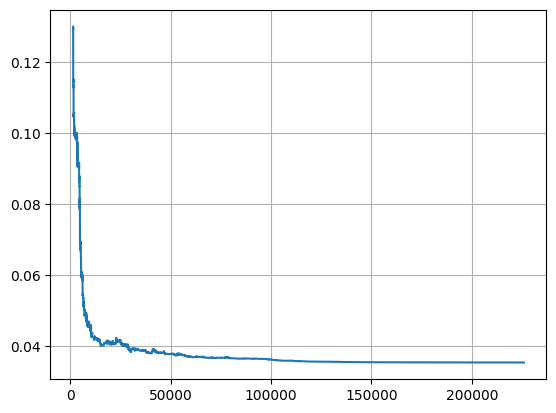

AttributeError: 'int' object has no attribute 'dot'

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Fxn - Randomly Initializing Phi

def initialize_vector():

    k= np.random.randint(5, 10)
    initial_phi = np.zeros(len(array[0]))
    random_indices = np.random.choice(len(initial_phi), k, replace=False)
    numbers = []
    numbers.append(np.random.uniform(0,0.5))
    random_max = 1 # or # np.random.uniform(0.9, 1)
    for _ in range(k-1):
           numbers.append(np.random.uniform(0, random_max - np.sum(numbers)))
    initial_phi[random_indices] = numbers
    return initial_phi

# Initialize Zero Vector and benchmark
zero_phi = np.zeros(len(array[0]))
zero_b = np.dot(array, zero_phi)
zero_error = np.linalg.norm(b - zero_b)

best_phi = zero_phi.copy()
best_error = zero_error.copy()
error_values = []
sim_values = []

print("Zero Vector Error:", zero_error)
# Function to calculate the custom error
def calculate_error(phi, penal_mult):
    computed_b = np.dot(array, phi)
    diff = b - computed_b                   # Expected to be positive
    penalty1 = -40*np.sum(diff[diff < 0])   # Ax>b penalty
    penalty2 = 0#.1*np.sum(diff[diff>0])       # L1 penalty
    penalty3 = 2*np.max(diff)               # Loo (inf) Penalty
    penalty4 = penal_mult*(1-sum(phi))**2   # L2 Norm Penalty
    penalties =  penalty1  + penalty3 + penalty4 +penalty2
    return penalties

# Initialize Zero Vector and bench mark
zero_phi = np.zeros(len(array[0]))
zero_b = np.dot(array, zero_phi)
zero_error = np.linalg.norm(b - zero_b)



# Parameters
T = 10e-4  # Initial temperature
T_min = 10e-8  # Minimum temperature
alpha = 0.96  # Cooling rate
num_iterations = 1000  # Iterations per temperature
penal_mult = 1
step_size = 0.05



# Initializations
iter = 0
counter = []
error_values = []
best_values_all = []
error_values = []
sim_values = []

best_phi = zero_phi.copy()
best_values_all.append(best_phi)
best_error = np.inf
current_phi = initialize_vector()
current_error = np.inf

# Perturbations
while T > T_min:
    
    for i in range(num_iterations):
        
        iter += 1
        # Make a small change to phi
        new_phi = current_phi.copy()
        index = np.random.randint(0, len(new_phi))
        change = np.random.uniform(-step_size, step_size)  # Adjust magnitude of change as needed
        new_phi[index] += change
        new_phi[new_phi < 0] = 0  # Ensure non-negativity
        
        #Ensure new phi sums to 1
        if T < 0.00001:
            new_phi = new_phi/np.sum(new_phi)

        # Check if the sum constraint is violated
        if np.sum(new_phi) > 1:
            #print('Skipping with sum more than 1')
            continue  # Skip the rest of the loop and do not update current_phi or current_error

        # Calculate new error
        new_error = calculate_error(new_phi, penal_mult)
        #print('New error: ', new_error, 'current_error', current_error, 'best_error', best_error)

        # Acceptance condition
        if new_error < current_error or np.random.uniform() < np.exp((current_error - new_error) / T):
            current_phi = new_phi.copy()
            current_error = new_error.copy()
            counter.append(iter)
            error_values.append(current_error/2)
            if new_error < best_error:
                best_error = new_error.copy()
                best_phi = new_phi.copy()
                #print("Best Error:", best_error/2, "Temperature:", T)
                # Add best phi as a new row to the best_values_all list
                best_values_all.append(best_phi)

    # Cool down
    T *= alpha
    step_size *= alpha
    penal_mult *= 1.002


# Visualization
plt.plot(counter[600:], error_values[600:])
plt.grid()
plt.show()
#print("Best Error:", best_error/2)
# Results
b_found = A.dot(best_phi)
bdifference = b - b_found
score = bdifference

print('b desired', b)
print('b found', np.round(b_found,4))
print()
print('difference', np.round(score,4))
print("Sup Norm is", np.max(bdifference))
print("L2 norm is", np.linalg.norm(bdifference, 2))
print()


## 3.1 A Posteriori Problem

### 3.1.1 Algorithm 2

I could not implement this for 2 reasons.
1) M* is not defined in the literature.
2) I did not perform a vertex walk for the v' Instead, I use supNorm Minimization above.


#### Algorithm 2 as presented

**Initialize**:
- M* <-- 2
- v' <-- 0
- {v'} is empty

**Begin vertex walk**:
- **Repeat**:
  1. Generate next vertex v'
  2. Compute vector sample L <-- F^T v'
  3. Find M*

  - If M* strictly decreased:
    - Empty {v'}
    - Remember new minimum M* value
    - Restart collection with v'

  - If M* did not change:
    - Add v' to {v'} collection

  - If M* strictly increased:
    - Do nothing

  - Vertex walk to next v' vertex

- **Until** v' = 0

**Monte Carlo Sampling**:
- Choose a large integer N.
- Transform link certitudes f_{i,j} into distribution functions, F_{i,j}, for each link Φ_i → L_j.

- **Repeat** N times:
  1. Select the values of the weights λ_k uniformly, randomly: P_{λ_k} = 1, λ_k ≥ 0.
  2. Form a solution vector phi~ = ∑_{v'} λ_k v'.
  3. Make random selections for each f_{i,j} based on certitude functions.
  4. Compute observed L~ = F^T *Phi~* and add to histogram.

- **End Repeat**

- Normalize the resulting raw histogram to unit area.


### 3.1.2 An Alternate Algorithm

- **Initialize**:
  - **L** = []
  - **Φ** = []
  - A = very large number
  - B = very large number

- **Input** $ \hat{L} $

- **Loop A times**:
  1. Sample $ F $ to create $ \hat{F} $.
  2. Solve $ \hat{F} \hat{\Phi} = \hat{L} $ for $ \hat{\Phi} $.
  3. Append $ \hat{\Phi} $ to **Φ**.

- **Loop B times**:
  1. Sample $ F $ to create $ \tilde{F} $.
  2. Sample **Φ** to create $ \tilde{\Phi} $.
  3. Solve $ \tilde{L} = \tilde{F} \tilde{\Phi} $ for $ \tilde{L} $.
  4. Append $ \tilde{L} $ to **L**.

- **Create a normalized histogram** of **L**.
- **Create a normalized histogram** of **Φ**.


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Load a new image
image_path = "new_character2.JPG"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_gray, (28, 28))
image_resized = 1 - (image_resized / 255.0)


kernel = np.ones((2, 2), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)
image_resized[image_resized < 0.85] = 0
image_resized[image_resized > 0.85] = 1

kernel = np.ones((1, 3), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
print('Model 11 predicts:', np.argmax(guess))
print('Softmax outputs:', np.round(guess, 2))
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model 11 predicts: 5
Softmax outputs: [[0.01 0.   0.03 0.04 0.02 0.66 0.03 0.01 0.17 0.04]]



In [83]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

A = 50_000 # 300 takes 30 seconds
B = 25_000

L = guess.copy()

L_all = []
Phi_all = []

# Random Block needed to get this to work:
num_classes = 10
num_images = 10000
results = np.random.rand(2, num_classes, num_images)

def solve_linear_program(F, L):
    # Ensure F and L are numpy arrays
    A = np.array(F)
    b = np.array(L)

    # Define the length of x
    x_len = A.shape[1]

    # Objective function: Minimize t
    c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
    c[-1] = 1  # Coefficient of t in the objective function

    # Augmented A and b matrix for constraints
    A_ub = np.hstack([A, -np.ones((A.shape[0], 1))])
    A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])
    b_ub = np.hstack([b, -b])

    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, x_len + 1))
    A_eq[0, :x_len] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

    # Solve the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # Extracting the solution
    x = res.x[:-1]

    
    return x


# Generate Phi_all
for acount in range(A):
    
    # Sample F
    F = np.zeros((num_classes, num_images))  # (10, 10000)
    for class_idx in range(num_classes):
        for image_idx in range(num_images):
            mean_confidence = results[0, class_idx, image_idx]
            std_deviation = results[1, class_idx, image_idx]
            F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)
    if acount%500 ==0:
        print(acount)

    # Solve for Phi
    phi = solve_linear_program(F, L)

    #print("sum of phi",np.sum(np.array(phi)))
    if phi is not None:
        # Append Phi
        Phi_all.append(phi)
    else:
        print("Received None for phi. Skipping.")

# Convert Phi_all to a numpy array for statistical calculations
Phi_all = np.array(Phi_all)

if Phi_all.size == 0:
    raise ValueError("Phi_all is empty. Ensure solve_linear_program is working correctly.")

# Calculate mean and standard deviation of each element in Phi_all
phi_mean = np.mean(Phi_all, axis=0)
phi_std = np.std(Phi_all, axis=0)
print("Done with Loop A")
# Generate L_all
for bcount in range(B):
    # Sample F
    F = np.zeros((num_classes, num_images))  # (10, 10000)
    for class_idx in range(num_classes):
        for image_idx in range(num_images):
            mean_confidence = results[0, class_idx, image_idx]
            std_deviation = results[1, class_idx, image_idx]
            F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)
    if bcount%500 ==0:
        print(bcount)
    # Sample Phi 
    phi_tilde = np.random.normal(phi_mean, phi_std) # I am not sure if this is the best way, or to generate a random index, and then choose that phi[random_index]
    # or to normalize after? Or pass through a softmax?

    # Solve for L
    Lhat = F.dot(phi_tilde)

    # Append L
    L_all.append(Lhat)


# Convert L_all to a numpy array
L_all = np.array(L_all)




0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
Done with Loop A
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500


Mean of each label:
Label 0: 0.40 var 0.095
Label 1: 0.40 var 0.098
Label 2: 0.38 var 0.088
Label 3: 0.40 var 0.093
Label 4: 0.39 var 0.093
Label 5: 0.53 var 0.109
Label 6: 0.40 var 0.094
Label 7: 0.39 var 0.093
Label 8: 0.41 var 0.092
Label 9: 0.39 var 0.094


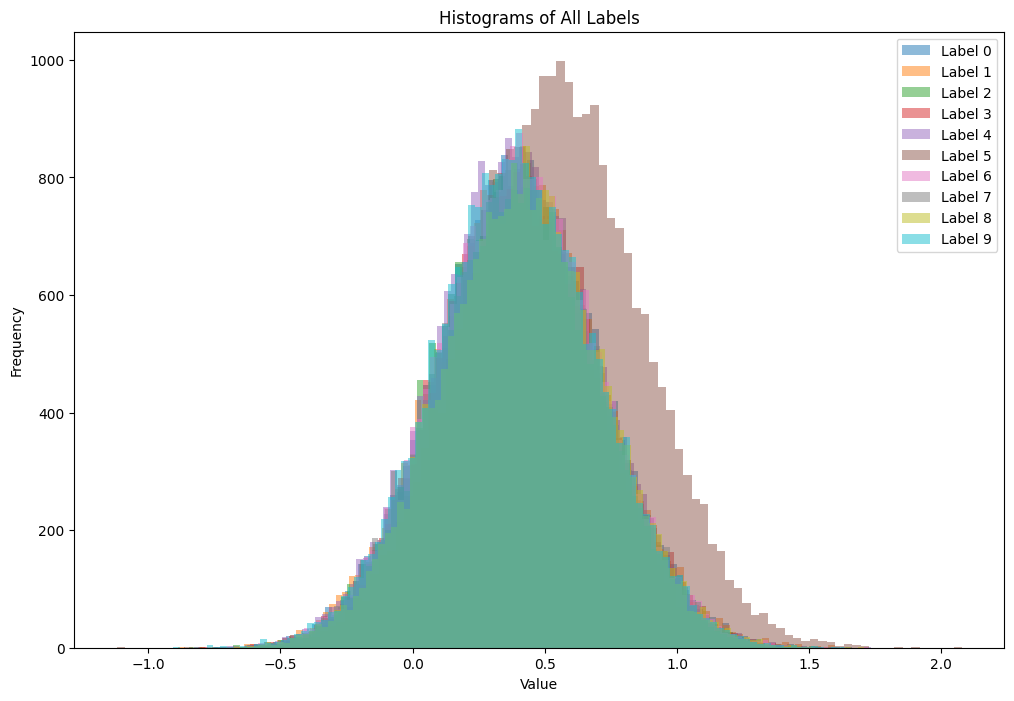

Mean of each label:
Label 0: 0.41 var 0.076
Label 1: 0.41 var 0.077
Label 2: 0.39 var 0.071
Label 3: 0.41 var 0.075
Label 4: 0.40 var 0.074
Label 5: 0.53 var 0.085
Label 6: 0.41 var 0.075
Label 7: 0.41 var 0.075
Label 8: 0.42 var 0.074
Label 9: 0.40 var 0.075


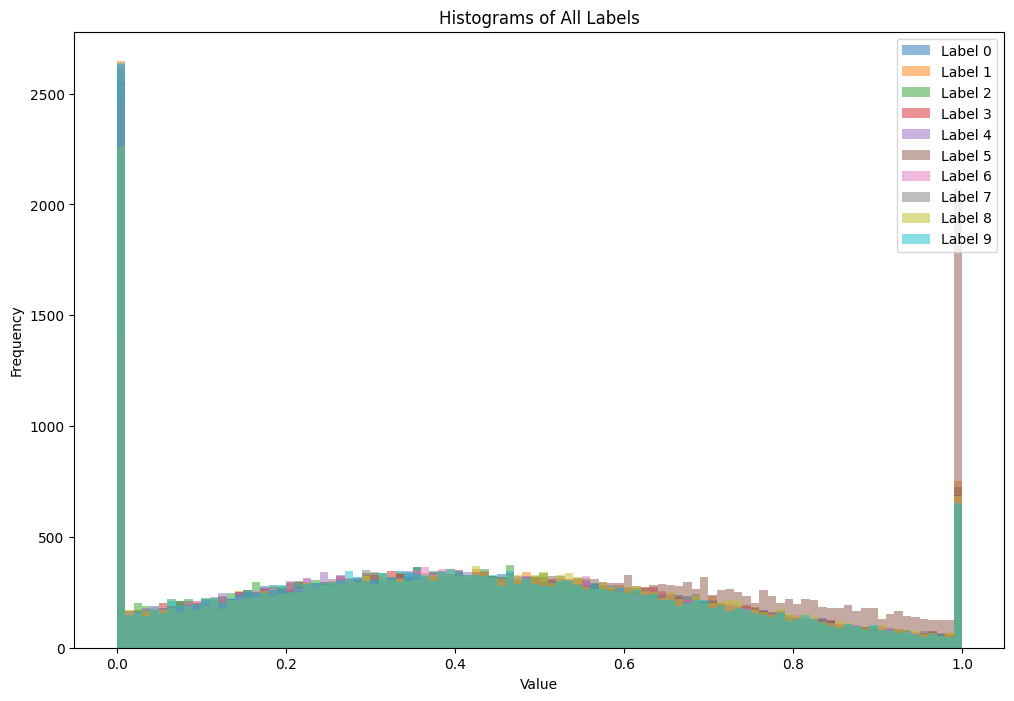

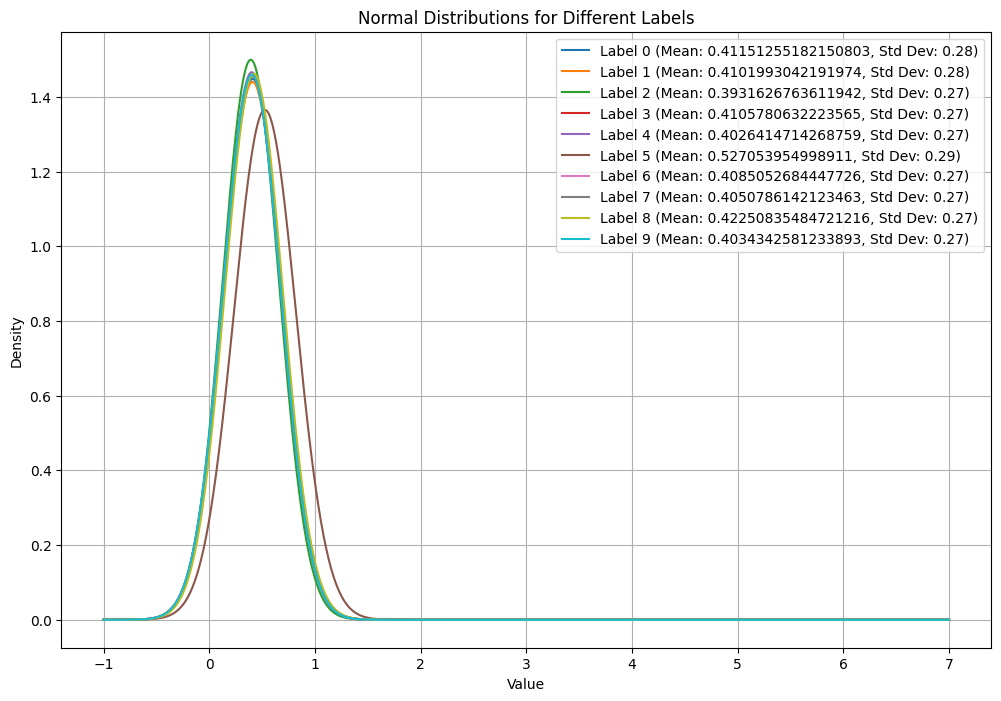

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

L_all2 = L_all.copy()
# Calculate and print the mean of each column
means = np.mean(L_all2, axis=0)
vars = np.var(L_all2, axis=0)
print("Mean of each label:")
for i, mean in enumerate(means):
    print(f"Label {i}: {mean:.2f}", "var", np.round(vars[i],3))



# Plot histograms on a single plot
plt.figure(figsize=(12, 8))

for i in range(L_all2.shape[1]):
    plt.hist(L_all2[:, i], bins=100, alpha=0.5, label=f'Label {i}')

plt.title('Histograms of All Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


# Showing a clipped version

L_all2 = np.clip(L_all2,0,1)
means = np.mean(L_all2, axis=0)
vars = np.var(L_all2, axis=0)
print("Mean of each label:")
for i, mean in enumerate(means):
    print(f"Label {i}: {mean:.2f}", "var", np.round(vars[i],3))



# Plot histograms on a single plot
plt.figure(figsize=(12, 8))

for i in range(L_all2.shape[1]):
    plt.hist(L_all2[:, i], bins=100, alpha=0.5, label=f'Label {i}')

plt.title('Histograms of All Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()


#### A faster implementation

In [88]:
import numpy as np
from scipy.optimize import linprog

A = 50_00
B = 25_00

L = guess.copy()
L_all = []
Phi_all = []

# Random Block needed to get this to work:
num_classes = 10
num_images = 10000
results = np.random.rand(2, num_classes, num_images)

def solve_linear_program(F, L):
    # Objective function: Minimize t
    c = np.zeros(F.shape[1] + 1)
    c[-1] = 1

    # Augmented A and b matrix for constraints
    A_ub = np.hstack([F, -np.ones((F.shape[0], 1))])
    A_ub = np.vstack([A_ub, np.hstack([-F, -np.ones((F.shape[0], 1))])])
    b_ub = np.hstack([L, -L])

    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, F.shape[1] + 1))
    A_eq[0, :F.shape[1]] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * F.shape[1] + [(0, None)]

    # Solve the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if res.success:
        return res.x[:-1]
    else:
        return None

# Pre-sample the random numbers
mean_confidences = results[0]
std_deviations = results[1]

# Generate Phi_all
for acount in range(A):
    # Sample F
    F = np.random.normal(mean_confidences, std_deviations)
    
    if acount % 500 == 0:
        print(acount)

    # Solve for Phi
    phi = solve_linear_program(F, L)
    if phi is not None:
        Phi_all.append(phi)
    else:
        print("Received None for phi. Skipping.")

# Convert Phi_all to a numpy array for statistical calculations
Phi_all = np.array(Phi_all)

if Phi_all.size == 0:
    raise ValueError("Phi_all is empty. Ensure solve_linear_program is working correctly.")

# Calculate mean and standard deviation of each element in Phi_all
phi_mean = np.mean(Phi_all, axis=0)
phi_std = np.std(Phi_all, axis=0)
print("Done with Loop A")

# Generate L_all
for bcount in range(B):
    # Sample F
    F = np.random.normal(mean_confidences, std_deviations)
    
    if bcount % 500 == 0:
        print(bcount)
    
    # Sample Phi from clipped Normal
    phi_tilde = np.random.normal(phi_mean, phi_std)
    
    # Solve for L
    Lhat = F.dot(phi_tilde)

    # Append L
    L_all.append(Lhat)

# Convert L_all to a numpy array
L_all = np.array(L_all)


0
500
1000
1500
2000
2500


KeyboardInterrupt: 

#### Even Faster Yet

Warning, this has made my computer crash multiple times, but should be 10 times faster in implementation if you can get it to work.

In [ ]:
import numpy as np
from scipy.optimize import linprog

A = 50_000
B = 25_000

L = guess.copy()

# Random Block needed to get this to work:
num_classes = 10
num_images = 10000
results = np.random.rand(2, num_classes, num_images)

def solve_linear_program(F, L):
    # Objective function: Minimize t
    c = np.zeros(F.shape[1] + 1)
    c[-1] = 1

    # Augmented A and b matrix for constraints
    A_ub = np.hstack([F, -np.ones((F.shape[0], 1))])
    A_ub = np.vstack([A_ub, -A_ub])
    b_ub = np.hstack([L, -L])

    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, F.shape[1] + 1))
    A_eq[0, :F.shape[1]] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * F.shape[1] + [(0, None)]

    # Solve the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if res.success:
        return res.x[:-1]
    else:
        return None

# Pre-sample the random numbers for all iterations at once
F_samples = np.random.normal(results[0][:, np.newaxis, :], results[1][:, np.newaxis, :], (num_classes, A, num_images))

# Vectorized solution for Phi_all
Phi_all = []
for acount in range(A):
    F = F_samples[:, acount, :]
    phi = solve_linear_program(F, L)
    if phi is not None:
        Phi_all.append(phi)
    else:
        print(f"Received None for phi at iteration {acount}. Skipping.")

# Convert Phi_all to a numpy array for statistical calculations
Phi_all = np.array(Phi_all)

if Phi_all.size == 0:
    raise ValueError("Phi_all is empty. Ensure solve_linear_program is working correctly.")

# Calculate mean and standard deviation of each element in Phi_all
phi_mean = np.mean(Phi_all, axis=0)
phi_std = np.std(Phi_all, axis=0)
print("Done with Loop A")

# Generate L_all using pre-sampled F matrices
F_samples_B = np.random.normal(results[0][:, np.newaxis, :], results[1][:, np.newaxis, :], (num_classes, B, num_images))
phi_tilde_samples = np.random.normal(phi_mean, phi_std, (B, num_images))

# Vectorized calculation of L_all
L_all = np.einsum('ijk,jk->ik', F_samples_B, phi_tilde_samples)

# Convert L_all to a numpy array
L_all = np.array(L_all)


# Appendix

#### 1.8 Special Request: Spreadsheet for Dr. Klienhenz

Unfortunately, I don't remember the details for this request.  
More research is needed for implementation.  

Run this with the smaller Ground Truth Data Set
cough cough - maybe something for Varun to do.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# True classes from the full test_labels
true_classes_full = np.argmax(test_labels, axis=1)

# Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
indices_per_class = 10  # Number of indices per class to achieve 100 images total
selected_indices = []

for digit in range(10):
    digit_indices = np.where(true_classes_full == digit)[0]
    selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
    selected_indices.extend(selected_digit_indices)

# Ensure the selected indices are shuffled to mix the digits
np.random.shuffle(selected_indices)

# Slicing the test_images and test_labels to get only the selected subset
subset_test_images = test_images[selected_indices]
subset_test_labels = test_labels[selected_indices]

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(subset_test_images)  # Predict with the model on the subset
    predictions.append(pred)

# Open a text file for writing results
with open('prediction_results.txt', 'w') as file:
    # Write header
    file.write("Image Index, Model Number, Predicted Class, Softmax Output\n")
    
    # For each model, write prediction results for each image
    for i in range(num_models):
        for j in range(len(subset_test_images)):
            predicted_class = np.argmax(predictions[i][j])
            softmax_output = np.max(predictions[i][j])
            expert_accuracy = scores[i]
            # Write to file
            file.write(f"{j}, Expert {i+1}, {expert_accuracy:.4f}, {predicted_class}, {softmax_output:.4f}\n")

print("Prediction results have been written to 'prediction_results.txt'.")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepWARNING:tensorflow:6 out of the last 319 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35db62040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━